In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yaml, sys, os
import pickle as pkl
import pulp, shutil, random
import time

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


import warnings
warnings.filterwarnings('ignore')

### Solve Integer Programming with Genetic Algorithm + Wisdom of Artificial Crowds

Integer Programming:

optimize $$c^T x$$

subject to $$ Ax \leq b$$

and $$x \geq 0, \; x \in Z, \; \; x_j \in [lb, ub] \; \forall j$$

In [2]:
# read in the parameters for genetic algorithm from inputs.yml
with open('inputs.yml', 'rb') as f:
    params = yaml.safe_load(f.read())

problem_size = params['n']
preload_data_flag = params['data_load']

### Data preperation

In [3]:
class Initializer:
    def __init__(self, n, n_constraints=10):
        self.n = n
        self.n_constraints = n_constraints
    def create_vector_c(self):
        return np.random.randint(-10, 10, self.n)
    def create_matrix_A(self):
        return np.random.randint(-5, 10, (self.n_constraints, self.n))
    def create_vector_b(self):
        return np.random.randint(self.n*2, self.n*10, self.n_constraints)
    def save_initial_data(self, c, A, b, filename=None):
        with open(filename, 'wb') as f:
            pkl.dump({'c': c, 'A': A, 'b': b}, f)
    
def load_initial_data(filename):
    with open(filename, 'rb') as f:
        data = pkl.load(f)
    return data['c'], data['A'], data['b']

if preload_data_flag:
    c, A, b = load_initial_data(filename=f'data/linear_programming_data_{problem_size}.pkl')
else:
    num_constraints = max(int(problem_size/16), 5)
    initializer = Initializer(problem_size, num_constraints)
    c = initializer.create_vector_c()
    A = initializer.create_matrix_A()
    b = initializer.create_vector_b()
    initializer.save_initial_data(c, A, b, filename=f'data/linear_programming_data_{problem_size}.pkl')
    sys.exit("Data initialized and saved. Please set 'data_load' to True in inputs.yml to load the data next time.")

print(A.shape)
print(b.shape)
print(c.shape)

(16, 256)
(16,)
(256,)


In [4]:
def solve_integer_programming(c, A, b, method='cbc'):
    """"
    Maximize cᵀx
    subject to Ax ≤ b
    and x ≥ 0, x ∈ Z
    """
    c = np.array(c)
    A = np.array(A)
    b = np.array(b)
    n_vars = len(c)
    n_constraints = len(b)
    # 1. Create a linear programming model (using PuLP)
    model = pulp.LpProblem("MatrixForm_LP", pulp.LpMaximize)
    # 2. Create optimization, integer variables 0 <= x0, x1, x2, ... <= 50
    x = pulp.LpVariable.dicts("x", range(n_vars), lowBound=0, upBound=50, cat="Integer")
    # 3. Objective: maximize cᵀx
    model += pulp.lpSum(c[j] * x[j] for j in range(n_vars))
    # 4. Constraints: A_i * x ≤ b_i
    for i in range(n_constraints):
        model += pulp.lpSum(A[i, j] * x[j] for j in range(n_vars)) <= b[i]
    # 5. Solve
    if method=='cbc':
        # Dual/Primal Simplex
        model.solve(pulp.COIN_CMD(path="/opt/homebrew/bin/cbc", msg=False))
    elif method=='glpk':
        # simplex + Interior Point
        model.solve(pulp.GLPK_CMD(msg=False))
    y = pulp.value(model.objective)
    return x, y

# Solve the integer programming:
# Maximize cᵀx
# subject to Ax ≤ b
# and x ≥ 0, x ∈ Z
if problem_size >= 255:
    print("Problem size too large for exact solver. Read in computed solution")
    filename = f"data/optimal_solution_{problem_size}.pkl"
    with open(filename, 'rb') as f:
        df = pkl.load(f)
    # calculate objective value
    obj_value = sum(df.loc[j, "Value"] * c[j] for j in range(problem_size))
    print("Objective value =", obj_value)
else:
    x, obj_value = solve_integer_programming(c, A, b, method='cbc')
    print("Objective value =", obj_value)
    # prepare data
    results_data = {
        "Variable": [f"x{j}" for j in range(problem_size)],
        "Value": [x[j].value() for j in range(problem_size)]
    }
    df = pd.DataFrame(results_data)
    # df = df.sort_values("Variable").reset_index(drop=True)
    df.to_pickle(f"data/optimal_solution_{problem_size}.pkl")
df[df["Value"] > 0].head(problem_size)

Problem size too large for exact solver. Read in computed solution
Objective value = 9194.0


,Variable,Value
5,x5,38.0
11,x11,1.0
21,x21,36.0
24,x24,32.0
25,x25,50.0
29,x29,49.0
31,x31,50.0
37,x37,1.0
39,x39,1.0
43,x43,50.0


### Genetic Algorithm

In [5]:
class GeneticAlgorithmWOC():
    def __init__(self, c, A, b, lb, ub):
        self.c = c
        self.A = A
        self.b = b
        with open('inputs.yml', 'rb') as f:
            params = yaml.safe_load(f.read())
        self.population_size = params['population_size']
        self.n_gen = params['num_generations']
        self.tournament_size = params['tournament_size']
        self.inv_p = params['inv_p']
        self.swap_p= params['swap_p']
        self.delta_mutate_p = params['delta_mutate_p']
        self.topsoln_frac = params['topsoln_frac']
        self.keep_children = params['keep_children']
        self.stall_patience = params['stall_patience']
        self.n_vars = len(c)
        self.n_constraints = len(b)
        self.lower_bound = lb
        self.upper_bound = ub
        self.use_lp_relaxation = params['use_lp_relaxation']
        self.lp_reinject_every = params['lp_reinject_every']
        self.n_lp_solutions_frac = params['n_lp_solutions_frac']

    @staticmethod
    def is_x_feasible(x, A, b):
        """ Quick check to see if Ax <= b (constraints) """
        return np.all(A @ np.array(x) <= b + 1e-9)
    
    def eval_fitness(self, solution):
        """
        Calculate the fitness of a solution, x: fitness = np.dot(c,x)
        Fitness is defined as the objective value if constraints are satisfied,
        otherwise a large negative penalty is applied.
        """
        # Check if solution is constrained feasible i.e., whether A*solution <= b,
        # If yes, return optimal c^T * x, else return large negative number
        if self.is_x_feasible(solution, self.A, self.b):
            return np.dot(self.c, solution)
        else:
            return -1e6
        
    ### HELPER FUNCTION, useful in ox and pmx crossover implementation and other functions
    def max_feasible_for_var(self, slack, col, lb, ub):
        """
        Inputs:
            slack  is the slack variable when having non-equality constraint, originally, s = b - Ax
            col    is a column of the constraint matrix A
            lb, ub are lower and upper bounds of each entry in solution vector x
        
        We will use this function for each x_j in the solution vector x

        Given slack with initially should be b - Ax or b[i] - SUM_k A[i,k] x[k]
        the following helps us evaluate how far can we increase x_j
        we know that constraint is: SUM_k A[i,k] x[k] <= b[i]
        currently, slack is:        s[i] = b[i] - SUM_k A[i,k] x[k]
        so increasing x[j] by delta adds A[i,j] * delta to left-hand side
        to stay feasible with constraint, we need A[i,j] * delta <= s[i]
        which means delta <= s[i] / A[i,j]
        => x[j] < min_i s[i] / A[i,j]
        we find the position 'pos' in col such that increasing x[pos] will reduce slack
        """
        pos = col > 0   # extract positions/indices in a column of A that are positive
        if np.any(pos):
            vmax_list = np.floor(slack[pos] / col[pos]).astype(int)
            vmax = int(vmax_list.min()) if vmax_list.size > 0 else ub
        else:
            # If all coefficients <= 0, increasing this variable doesn't hurt feasibility
            vmax = ub
        return min(ub, max(lb, vmax))   # choose feasible value for x[j]

    def generate_feasible_individual(self):
        """
        Greedy constructive heuristic to generate feasible solution x in [lb, ub]^n s.t. A x <= b is satisfied.
        """
        n = self.n_vars
        lb = int(self.lower_bound)
        ub = int(self.upper_bound)
        x = np.zeros(n, dtype=int)
        slack = self.b.astype(float) - self.A @ x   # start with full slack = b - Ax
        order = np.random.permutation(n)            # random permutation from 0 to n-1

        # for each column in matrix A,
        #   we check if col is positive
        for j in order:
            col = self.A[:, j].astype(float)    # this is how much constrait i's LHS changes when increasing x[j]
            vmax = self.max_feasible_for_var(slack, col, lb, ub)
            vmin = lb
            # choose a value for x[j] within [vmin, vmax] 
            if vmax < vmin:
                # No room to increase without violating constraints; pick the safest value
                val = vmin if vmin == 0 else 0
            else:
                val = np.random.randint(vmin, vmax + 1)
            # update slack
            x[j] = int(val)
            slack = slack - col * val
        return x.tolist()

    # def create_init_popn(self):
    #     """
    #     Create an initial population of feasible solutions (A x <= b) with x integer in [lb, ub].
    #     """
    #     initial_pop = []
    #     tries_per_individual = 50
    #     for _ in range(self.population_size):
    #         x = None
    #         # Try greedy construction multiple times with different orders
    #         for __ in range(tries_per_individual):
    #             candidate = self.generate_feasible_individual()
    #             if self.is_x_feasible(candidate, self.A, self.b):
    #                 x = candidate
    #                 break
    #         initial_pop.append(x)
    #     return initial_pop
    
    def create_init_popn(self):
        initial = []
        tries_per_individual = 20
        while len(initial) < self.population_size:
            x = None
            for _ in range(tries_per_individual):
                cand = self.generate_feasible_individual()
                if self.is_x_feasible(cand, self.A, self.b):
                    x = cand; break
            if x is None:
                # fallback: random integer then repair
                randx = np.random.randint(self.lower_bound, self.upper_bound+1, size=self.n_vars).tolist()
                x = self.solution_improve(randx)
            initial.append(x)
        return initial
    
    def choose_best_individuals(self, population, fitnesses):
        """
        Select the top fraction of individuals based on their fitness values.
        Top fraction is given by self.topsoln_frac.
        This function will be used in selecting the first few candidates in the next_population.
        """
        num_top = max(1, int(self.topsoln_frac * len(population)))  # num_top = number of top-candidates to be selected
        sorted_indices = np.argsort(fitnesses)[::-1]                # indices of num_top candidates that have best fitnesses
        best_indices = sorted_indices[:num_top]                     # sort the indices
        best_individuals = [population[i] for i in best_indices]    # extract best solutions (these should have largest fitness-values)
        return best_individuals
    
    def randomize_good_solution(self, population, fitnesses, k=10):
        """
        Choose a reasonably good solution out of "k" randomly selected solutions
        """
        k = self.tournament_size
        idx = np.random.choice(len(population), size=k, replace=False)
        best = max(idx, key=lambda i: fitnesses[i])
        return population[best]
    
    ################################# CROSSOVER IMPLEMENTATION #################################
    def ox(self,p1,p2):
        """ Order Crossover """
        n = self.n_vars
        assert len(p1) == n and len(p2) == n, "Parents must have length n_vars"
        lb = int(self.lower_bound)
        ub = int(self.upper_bound)

        # Find the slice range randomly for ox cross over
        slice_start, slice_end = sorted(np.random.choice(np.arange(n), size=2, replace=False))

        def build_child(p1, p2):
            """
            p1 = parent 1, p2 = parent 2
            Note: we will take a slice from p1 i.e., p1[slice_start, slice_end] and capped with constraints feasibility
                  then fill remaining indices of child by p2, also capped with constraints feasibility
            """
            x = np.zeros(n, dtype=int)
            # first compute slack
            slack = self.b.astype(float) - self.A @ x
            # 1) copy the middle slice from 'p1' but cap by feasibility
            for k in range(slice_start, slice_end+1):
                col = self.A[:, k].astype(float)        # extract column k which has an effect on x[k]
                gene = int(p1[k])                       # extract the wanted 'gene' from p1
                # then compute the max feasible value for x[k], called vmax
                vmax = self.max_feasible_for_var(slack, col, lb, ub)
                val = max(lb, min(gene, vmax))          # choose x[k]'s value between [lb, gene]
                x[k] = val
                slack = slack - col * val               # update slack after choosing x[k]
            # 2) fill remaining positions in cyclic order using 'p2'
            for k in list(range(slice_end + 1, n)) + list(range(0, slice_start)):
                col = self.A[:, k].astype(float)        # extract column k which has an effect on x[k]
                gene = int(p2[k])                       # extract 'gene' from p2
                # then compute the max feasible value for x[k], called vmax
                # then follow the same logic as above for-loop to fill the remaining slot for our child
                vmax = self.max_feasible_for_var(slack, col, lb, ub)
                val = max(lb, min(gene, vmax))
                x[k] = val
                slack = slack - col * val
            return x.tolist()

        # return 2 children
        return build_child(p1, p2), build_child(p2, p1)
    
    def pmx(self,p1,p2):
        """ Partially Mapped Crossover """
        n = self.n_vars
        assert len(p1) == n and len(p2) == n, "Parents must have length n_vars"
        lb = int(self.lower_bound)
        ub = int(self.upper_bound)

        # find the slice range randomly
        slice_start, slice_end = sorted(np.random.choice(np.arange(n), size=2, replace=False))
        # mapping from P2 -> P1 over the segment [slice_start, slice_end+1]:
        # seg_map_12: on slice: [slice_start, slice_end+1], we create a mapping of element in p1 to p2
        seg_map_12 = {k: (int(p1[k]), int(p2[k])) for k in range(slice_start, slice_end+1)}  # index -> (p1_val, p2_val)
        # map_p2_to_p1: value mapping (by PMX): a value from p2 maps to corresponding value in p1 in the segment
        map_p2_to_p1 = {v: u for (_, (u, v)) in seg_map_12.items()}
        # segment_vals_p1: the set of values in p1 that will be used by perform_mapping()
        segment_vals_p1 = set(int(p1[k]) for k in range(slice_start, slice_end+1))

        def perform_mapping(g):
            """
            Follow mapping P2->P1 until we get a value not in the P1 segment
            This is PMX logic: if the desired value g has conflict with segment that's been copied,
            then we need to follow the mapping chain: g <- map_p2_to_p1[g] <- ... 
            until we get a value that is not in p1 segment
            """
            seen = 0; n = self.n_vars
            while g in segment_vals_p1 and g in map_p2_to_p1:
                g = map_p2_to_p1[g]
                seen += 1
                if seen > n:  # avoid pathological loops
                    break
            return g
        
        def build_child(p1, p2):
            """
            p1 = parent1, p2 = parent2
            To create a child from p1 & p2:
            - Copy a random segment from p1 i.e., p1[slice_start, slice_end]
            - Fill the rest by doing a mapping from p2 -> p1.
            - Enforce constraints feasibility
            """
            x = np.zeros(n, dtype=int)
            slack = self.b.astype(float) - self.A @ x
            # 1) copy the middle segment from 'p1' with feasibility clamp
            for k in range(slice_start, slice_end+1):
                col = self.A[:, k].astype(float)
                gene = int(p1[k])
                vmax = self.max_feasible_for_var(slack, col, lb, ub)
                val = max(lb, min(gene, vmax))
                x[k] = val
                slack = slack - col * val
            # 2) fill outside segment positions using PMX mapping from 'p2'
            for k in list(range(0, slice_start)) + list(range(slice_end+1, n)):
                col = self.A[:, k].astype(float)
                gene = int(p2[k])
                gene = perform_mapping(gene)
                vmax = self.max_feasible_for_var(slack, col, lb, ub)
                val = max(lb, min(gene, vmax))
                x[k] = val
                slack = slack - col * val
            return x.tolist()

        # return 2 childrens
        return build_child(p1, p2), build_child(p2, p1)
    
    
    # For Integer Programming, it is better to use uniform, one-point, and blend crossovers
    def uniform_crossover(self, p1, p2):
        """Uniform crossover for integer vectors; no feasibility enforced here.
        Create a random mask of size n_vars with True/False values.
        Example: mask = [T, F, T, T, F] => child = [p1[0], p2[1], p1[2], p1[3], p2[4]]
        Uniform crossover: each gene is chosen from either parent with equal probability.
                           each gene is treated independently.
        """
        n = self.n_vars
        child = np.empty(n, dtype=int)
        mask = np.random.rand(n) < 0.5      # mask is a boolean array of size n
        # choose child's genes from p1 or p2 based on mask
        child = np.where(mask, np.asarray(p1, int), np.asarray(p2, int))
        return np.clip(child, self.lower_bound, self.upper_bound).tolist() # clip child within bounds to help reduce infeasibility

    def one_point_crossover(self, p1, p2):
        """ One-point crossover for integer vectors; no feasibility enforced here.
        Select a random cut point, and swap the tails of p1 and p2 to create two children.
        Example: cut = 3
        p1 = [1, 2, 3, | 4, 5]
        p2 = [6, 7, 8, | 9, 0]
        => c1 = [1, 2, 3, 9, 0]
           c2 = [6, 7, 8, 4, 5]
        One-point crossover: swap partially variable groups, preserves numeric meaning
        """
        n = self.n_vars
        cut = np.random.randint(1, n)
        c1 = np.array(p1, dtype=int).copy()
        c2 = np.array(p2, dtype=int).copy()
        c1[cut:], c2[cut:] = c2[cut:], c1[cut:].copy()
        # enforce box bounds
        c1 = np.clip(c1, self.lower_bound, self.upper_bound)
        c2 = np.clip(c2, self.lower_bound, self.upper_bound)
        return c1.tolist(), c2.tolist()
    
    def blend_crossover(self, p1, p2, alpha=0.5):
        """
        Blend (arithmetic) crossover for bounded integer vectors.
        For each gene j:
            child[j] = round( (1 - w_j) * p1[j] + w_j * p2[j] )
            where w_j is sampled from U(-alpha, 1 + alpha)
        This allows mild extrapolation beyond parents when alpha > 0.
        """
        lb, ub = int(self.lower_bound), int(self.upper_bound)
        n = self.n_vars
        p1 = np.asarray(p1, dtype=float)
        p2 = np.asarray(p2, dtype=float)
        # Random weights w_j ~ Uniform(-alpha, 1 + alpha)
        w = np.random.uniform(-alpha, 1 + alpha, size=n)
        # Compute blended child (weighted average of parents)
        child = (1 - w) * p1 + w * p2
        # Round to nearest integer and clip to bounds
        child = np.rint(np.clip(child, lb, ub)).astype(int)
        return child.tolist()
    
    ###################################################################################################


    ##################################### MUTATION IMPLEMENTATION #####################################
    
    def mutate(self, parent, type='swap', p=0.15):
        if random.random() > p:
            return parent.copy()
        n = self.n_vars
        lb = int(self.lower_bound)
        ub = int(self.upper_bound)

        # For swap:      find 2 indices that we need to perform swap on the parent solution
        # For inversion: find 2 indices that define the ranges of inversion within parent solution
        i, j = sorted(np.random.choice(n, size=2, replace=False))
        # recall: input is the 'parent' solution
        parent = parent.copy()
        if type  == 'swap':
            parent[i], parent[j] = parent[j], parent[i]
            prioritized_indices = [i,j]
        elif type== 'inversion':
            parent[i:j+1] = parent[i:j+1][::-1]
            prioritized_indices = list(range(i, j+1))

        # In the above, we have done the operations on parent when mutation = swap or inversion
        # Now, we need to ensure that the created child (from parent) satisfy the feasible constraints (A*child <= b)
        x  = np.zeros(n, dtype=int)     # initialize child
        slack = self.b.astype(float) - self.A @ x
        order, examined_indices  = [], []
        # we need to priority the swap indices first (if mutation is swap)
        # else, if mutation is inverse, then we priority indices in the inversion range: [i, i+1, ..., j-1, j]
        for idx in prioritized_indices:
            if 0 <= idx < n and idx not in examined_indices:
                order.append(int(idx)); examined_indices.append(int(idx))
        # after inserting priority indices, we populate other indices into the list order
        for j in range(n):
            if j not in examined_indices:
                order.append(j)
        # here, kinda repeat what we've done with cross-over i.e., finding maximum possible integer value
        #       for each x[j] s.t. Ax <= b is still satisfied
        for j in order:
            col = self.A[:, j].astype(float)
            gene = int(parent[j])
            vmax = self.max_feasible_for_var(slack, col, lb, ub)
            val = max(lb, min(gene, vmax))
            x[j] = val
            slack = slack - col * val
        return x.tolist()
    
    # For Integer Programming, it is better to use delta_mutation:
    def delta_mutate(self, x, p=0.2, max_changes=3, step=3):
        """
        With prob p, perturb up to max_changes variables by +/- up to 'step' units.
        The idea is to perturb the solution slightly to explore nearby solutions while maintaining feasibility of constraints.
        """
        if np.random.rand() > p:
            return x.copy()
        n = self.n_vars
        x = np.array(x, dtype=int)
        # select random x_j to perturb
        idxs = np.random.choice(n, size=np.random.randint(1, max_changes+1), replace=False)
        for j in idxs:
            delta = np.random.randint(-step, step+1)
            x[j] = int(np.clip(x[j] + delta, self.lower_bound, self.upper_bound))
        return x.tolist()


    ###################################################################################################


    ############################### SOLUTION IMPROVEMENT IMPLEMENTATION ###############################

    def solution_improve(self, x):
        """
        Remark: in the new approach using uniform_crossover and one_point_crossover with delta_mutate,
                we may generate infeasible solutions more often.
                Hence, we need a repair mechanism to fix infeasible solutions.
        If infeasible, greedily reduce variables to satisfy Ax <= b while losing as little c^T x as possible.
        Heuristic: prioritize variables by (benefit loss per unit violation fix).
        """
        A, b, c = map(np.array, (self.A, self.b, self.c))
        x = np.clip(np.array(x, float), self.lower_bound, self.upper_bound)
        lb, ub = float(self.lower_bound), float(self.upper_bound)

        # Try for 50 iterations to fix violations
        n_runs = min(50, self.n_vars * 2)
        for _ in range(n_runs):
            viol = A @ x - b                    # violation amount at each entry
            if np.all(viol <= 1e-9): break      # feasible condition

            violated = viol > 1e-9              # flag (True/False) of violated constraints, is a m x 1 boolean array
            pos_mask = (A > 0)                  # boolean matrix: m x n boolean matrix
            # calculate help_factor_j: for each variable j, how much reducing x[j] helps fix violations
            # help_factor_j[j] = sum(A[i,j] * viol[i]) for all i where 
            #               A[i,j] > 0 and constraint i is violated -- row sum
            help_factor_j = np.sum(A * (violated[:, None] & pos_mask), axis=0)
            with np.errstate(divide='ignore', invalid='ignore'):
                # calculate the ratio: this is the cost-benefit ratio for reducing x[j]
                # i.e., reduce x[j] by 1 unit helps fix 'help_factor_j' violation amount, at cost of losing c[j] benefit
                c_star = np.maximum(self.c, 0.0)  # only penalize loss when c[j] > 0
                ratio = np.where(help_factor_j > 1e-12, c_star / help_factor_j, np.inf)

            # choose variable j with minimum ratio to reduce because it gives best benefit per unit violation fix
            # since ratio defines cost-benefit for reducing x[j] i.e., smaller ratio is better
            # in other words, reduce variable j by 1 unit yield the smallest cost decrease in objective.
            j = np.argmin(ratio)
            if not np.isfinite(ratio[j]) or help_factor_j[j] <= 1e-12:
                candidates = np.where(help_factor_j > 1e-12)[0]
                if not len(candidates): break
                j = np.random.choice(candidates)

            col = A[:, j]
            pos_rows = (col > 0) & violated     # find rows i where A[i,j] > 0 and constraint i is violated
            # calculate how much we need to reduce x[j] to fix all violations
            # remark this is taking slack[pos_rows] / A[:, pos_rows]
            delta_needed = np.max(viol[pos_rows] / col[pos_rows]) if np.any(pos_rows) else 0.0
            # new value for x[j]: either lb or reduce by delta_needed (at least 1.0 to make progress)
            new_val = max(lb, x[j] - max(1.0, np.ceil(delta_needed)))
            if new_val == x[j]: 
                help_factor_j[j] = 0.0
                continue
            x[j] = new_val

        return np.rint(np.clip(x, lb, ub)).astype(int).tolist()
    
    
    def fill_slack_improve(self, x):
        """
        After solution_improve(), we may have feasible solution x but with slack in constraints.
        Try to greedily increase variables to consume slack where c_j > 0.
        Heuristic approach: prioritize variables by "benefit per unit slack usage".

        For each variable x[j], look at column A[:, j],
        - If ANY A[i, j] > 0, compute how much we can increase x[j] without violating constraints, maximum increase is:
            vmax = min_{i: A[i,j]>0} slack[i] / A[i,j]
            Then increase x[j] by delta = min(vmax, ub - x[j]) if c[j] > 0.

        - If ALL A[i,j] <= 0, increasing x[j] freely never reduces slack (since A[i,j]*delta <= 0 for delta>0),

        - If SOME A[i,j] < 0, can safely increase x[j] to some bound without violating constraints.
            - If c[j] > 0, increase x[j] by a small amount (e.g., 1 unit) up to ub.
            - If c[j] <= 0, leave x[j] as is.
        """
        # assume x is feasible; greedily increase variables to consume slack where c_j > 0
        A = self.A.astype(float); b = self.b.astype(float)
        x = np.array(x, dtype=float)
        lb, ub = float(self.lower_bound), float(self.upper_bound)
        slack = b - A @ x
        # Only columns with positive coefficients can consume slack
        pos_mask = (A > 0)  # boolean matrix: A_ij > 0
                            # if A_ij > 0, increasing x_j reduces slack in constraint i
                            # if A_ij <=0, increasing x_j does not reduce slack in constraint i and might even relax constraint i
        # Heuristic “bang-for-slack”: benefit per unit slack usage
        score = np.zeros(self.n_vars)
        for j in range(self.n_vars):
            denom = np.sum(np.where(pos_mask[:, j], A[:, j], 0.0))      # denom[j] = sum of A[i,j] for all i where A[i,j]>0 for each j
                                                                        # denom = measure how quickly increasing x_j reduces slack.
            score[j] = self.c[j] / (denom + 1e-10)                      # benefit per unit increase / slack pressure per unit increase 
                                                                        # large score --> good to increase x_j
        order = np.argsort(-score)  # descending
        for j in order:
            col = A[:, j]
            pos = col > 0
            if not np.any(pos):                         # increasing x_j doesn't reduce slack
                if self.c[j] > 0:
                    x[j] = min(ub, x[j] + 1.0)          # tiny nudge (free if all col<=0)
                continue
            delta_max = np.min(slack[pos] / col[pos])   # max delta allowed, delta = slack[i] / A[i,j] for each i where A[i,j]>0
            if delta_max > 0:
                delta = min(delta_max, ub - x[j])
                if delta > 0.5 and self.c[j] > 0:       # help avoid tiny increases which could happen and we only increase if c[j]>0
                    delta = np.floor(delta)
                    x[j] += delta
                    slack -= col * delta
        return np.rint(np.clip(x, lb, ub)).astype(int).tolist()
    
    def local_improve(self, x, max_steps=3):
        x = np.array(x, dtype=int)
        lb, ub = int(self.lower_bound), int(self.upper_bound)
        A = self.A; b = self.b; c = self.c
        lhs = A @ x
        local_deltas = [-3, -2, -1, 1, 2, 3]  # small perturbations to try
        for _ in range(max_steps):
            best_gain = 0; best_j = None; best_delta = 0
            # try small deltas +/-1 on top-K c_j (prune search)
            K = min(32, self.n_vars)
            # Here, we look at the top-K variables with highest c_j values
            # and try to perturb the corresponding x_j by +/- 1 unit to see if we can improve the objective while maintaining constraints feasibility
            idx_for_largest_c = np.argsort(-c)[:K]
            for j in idx_for_largest_c:
                for delta in local_deltas:                          # trial values: delta = -3, -2, -1, 1, 2, 3
                    x_j_new = x[j] + delta                          # take the corresponding x[j] and perturb it by delta
                    if x_j_new < lb or x_j_new > ub: continue       # if new x_j is out of bounds, skip
                    lhs_new = lhs + A[:, j] * delta                 # compute new LHS (of constraints) after perturbation
                    if np.all(lhs_new <= b + 1e-9):                 # if   new LHS satisfies constraints
                        gain = c[j] * delta                         # then new gain in objective is c[j] * delta
                        if gain > best_gain:                        # if gain is better than best_gain found so far, update best_gain, best_j
                            best_gain, best_j, best_delta = gain, j, delta
            if best_gain <= 0: break
            # apply best move
            x[best_j] += best_delta                                 # out of K candidates, we have found the index best_j with the best gain in objective
            lhs = lhs + A[:, best_j] * best_delta                   # update LHS accordingly with the best gain in x_j
        return x.astype(int).tolist()
    
    # combining above 3 functions into one
    def perform_soln_improvement(self, x):
        """
        Given a solution x, perform local improvement to enhance its fitness.
        This can be done by trying small perturbations to the solution and checking if fitness improves.
        """
        x = self.solution_improve(x)
        x = self.fill_slack_improve(x)
        x = self.local_improve(x, max_steps=5)
        return x

    ###################################################################################################


    ############################## SOLVING LINEAR PROGRAMMING RELAXATION ##############################
    def solve_lp_relaxation(self):
        """
        Solve LP: max c^T x  s.t. A x <= b, lb <= x <= ub (continuous).
        Returns: x_lp (float np.array), z_lp (float), rc (reduced costs or None)
        Remark:
        - This is very efficient since x is continuous; we can use scipy.optimize.linprog with method='highs'.
        - LP relaxation is convex, so global optimum is guaranteed and is computationally efficient.
        """
        n = self.n_vars
        # normalize bounds to arrays
        lb = self.lower_bound if np.ndim(self.lower_bound) else np.full(n, self.lower_bound, dtype=float)
        ub = self.upper_bound if np.ndim(self.upper_bound) else np.full(n, self.upper_bound, dtype=float)

        # Try HIGHS solver first
        from scipy.optimize import linprog
        res = linprog(
            c=-np.asarray(self.c, dtype=float),     # maximize -> minimize -c
            A_ub=self.A.astype(float),
            b_ub=self.b.astype(float),
            bounds=list(zip(lb, ub)),
            method="highs",
        )
        if res.success:
            x_lp = np.asarray(res.x, dtype=float)
            z_lp = float(-res.fun)
            # reduced costs (HiGHS exposes them via res.reduced_costs in newer SciPy)
            rc = getattr(res, "reduced_costs", None)
            if rc is not None:
                rc = np.asarray(rc, dtype=float)
            return x_lp, z_lp, rc
        
    def round_lp_soln(self, x_lp):
        """ Round x_lp to {integers}, and make sure it is within bounds """
        n = self.n_vars
        lb = self.lower_bound if np.ndim(self.lower_bound) else np.full(n, self.lower_bound, dtype=float)
        ub = self.upper_bound if np.ndim(self.upper_bound) else np.full(n, self.upper_bound, dtype=float)
        frac = x_lp - np.floor(x_lp)
        toss = np.random.rand(n)
        x = np.floor(x_lp) + (toss < frac)  # 0/1 random rounding per coordinate
        return np.clip(x, lb, ub).astype(int)
    
    def generate_some_lp_solutions(self, n_soln=12, trials_per_seed=3):
        """
        Produce several high-quality solutions from LP relaxation.
        Each solution: do rounding -> improvement (to stay feasible).
        If reduced costs available, bias small repair choices.
        """
        x_lp, _, _ = self.solve_lp_relaxation()
        lp_solns = []

        for _ in range(n_soln):
            x_best = None
            z_best = -np.inf
            for _ in range(trials_per_seed):
                x = self.round_lp_soln(x_lp)
                # your existing feasibility + improvement pipeline
                x = self.perform_soln_improvement(x)
                z = float(self.c @ np.asarray(x, dtype=float))
                if z > z_best:
                    z_best, x_best = z, x
            lp_solns.append(x_best)

        # Optionally sort by fitness (best first)
        lp_solns.sort(key=lambda s: float(self.c @ np.asarray(s, float)), reverse=True)
        return lp_solns

    def reinitialize_population_using_lprelax_random(self, population):
        """
        Given current population, replace some worst individuals with
        some of the best LP-relaxation-based solutions, if they are better.
        """
        pop = list(population)
        n_lp_solns = max(1, int(self.n_lp_solutions_frac * self.population_size))
        lp_solns = self.generate_some_lp_solutions(n_soln=n_lp_solns)
        if not lp_solns or not pop:
            return pop
        # calculate fitness for current population and the generated lp_solns:
        pop_fit = np.asarray([self.eval_fitness(w) for w in pop], dtype=float)
        lp_fit  = np.asarray([self.eval_fitness(w) for w in lp_solns], dtype=float)
        # find indices of worst individuals in pop and best individuals in lp_solns
        k = min(len(lp_solns), len(pop))
        pop_worst_idx = np.argpartition(pop_fit, k-1)[:k]       # worst k solutions in pop
        lp_best_idx   = np.argsort(-lp_fit)[:k]                 # top   k solutions in lp_solns
        # replace worst in pop with best from lp_solns if better
        # by iterating through lp_best_idx and pop_worst_idx in pairs
        x_in_pop = {tuple(map(int, x)) for x in pop}
        for si, wi in zip(lp_best_idx, pop_worst_idx):      # note: lp_best_idx should have same size as pop_worst_idx
            s = lp_solns[si]; fs = lp_fit[si]
            if fs > pop_fit[wi]:                            # only replace if lp_fit[si] is strictly better than pop_fit[wi]
                t = tuple(map(int, s))
                if t not in x_in_pop:
                    pop[wi] = s; pop_fit[wi] = fs
                    x_in_pop.add(t)
        return pop

    def reinject_lp_solutions(self, population, n_new=5):
        """
        Given current population, replace some worst solutions with
        some of the best LP-relaxation-based solutions, if lp-based solutions are better.
        This is done at every 20-30 generations to maintain diversity and quality.
        """
        lp_solns = self.generate_some_lp_solutions(n_soln=n_new, trials_per_seed=3)
        # Compute fitness for both sets
        pop_fit = np.array([self.eval_fitness(w) for w in population], dtype=float)
        lp_fit  = np.array([self.eval_fitness(w) for w in lp_solns],   dtype=float)
        # Sort population ascending (worst first) and LP solutions descending (best first)
        # For population fitness, smaller is worse; 
        # For LP fitness, larger is better: the way we do it is to sort -lp_fit ascending and extract the first len(pop_worst_idx) indices
        pop_worst_idx = np.argsort(pop_fit)[:n_new]
        lp_best_idx   = np.argsort(-lp_fit)[:n_new]

        # Replace worst population members with best LP seeds (1-to-1 in rank order)
        for wi, si in zip(pop_worst_idx, lp_best_idx):
            if lp_fit[si] > pop_fit[wi]:
                pop[wi] = lp_solns[si]
                pop_fit[wi] = lp_fit[si]
        return population
    
    ###################################################################################################
    ########################### GENETIC ALGORITHM MAIN LOOP IMPLEMENTATION ############################
    ###################################################################################################
    def genetic_alg_main(self, seed=42):
        """
        Main loop for the genetic algorithm:
        - GA uses:
            - uniform, one-point, and blend crossovers to generate several children
            - delta mutation to perturb children
            - solution improvement via repair, fill slack, and local search
            - selection via tournament selection
            - early stopping if no improvement in best fitness for "stall_patience" generations
            - OPTIONAL: LP-relaxation-based solution injection at initialization and during evolution (HIGHLY RECOMMENDED)
            - This is hybridization of GA with LP relaxation to improve solution quality and convergence speed.
        - WOC:
        """
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        # 1. Create initial population
        population = self.create_init_popn()
        if self.use_lp_relaxation:
            population = self.reinitialize_population_using_lprelax_random(population)
        # perform some improvement on initial population
        population = [self.perform_soln_improvement(elt) for elt in population]
        best_fitness_over_time = []
        fitness = [self.eval_fitness(w) for w in population]
        best_fitness = max(fitness)
        best_solution = population[fitness.index(best_fitness)]

        stall = 0
        hist_best, hist_mean = [], []
        for gen in range(self.n_gen):
            curr_best_fitness = max(fitness)
            curr_mean = np.mean(fitness)
            hist_best.append(curr_best_fitness)
            hist_mean.append(curr_mean)
            if curr_best_fitness > best_fitness:
                best_fitness = curr_best_fitness
                best_solution= population[fitness.index(best_fitness)]
                stall = 0
            else:
                stall += 1
                # if stall >= self.stall_patience:
                # # Perform restart: keep top 50% and generate 50% new individuals
                #     restart_n = int(0.5 * self.population_size)
                #     newbies = [self.perform_soln_improvement(self.generate_feasible_individual()) for _ in range(restart_n)]
                #     population = self.choose_best_individuals(population, fitness)[:self.population_size - restart_n] + newbies
                #     fitness = [self.eval_fitness(w) for w in population]    # recompute fitness for the new population
                #     stall = 0
                #     continue
                # Early Stopping Condition (if no improvement in best fitness for "stall_patience" generations)
                if stall >= self.stall_patience:
                    print(f"Early stopping at generation {gen} due to no improvement in best fitness for {self.stall_patience} generations.")
                    break

            # find next population
            next_population = self.choose_best_individuals(population, fitness)
            next_population = [self.perform_soln_improvement(elt) for elt in next_population]
            while len(next_population) < self.population_size:
                # select 2 parents using randomize_good_solution
                p1 = self.randomize_good_solution(population, fitness)
                p2 = self.randomize_good_solution(population, fitness)
                while p1 == p2: # rarely happen
                    p2 = self.randomize_good_solution(population, fitness)

                #-----------------------------------------------------------------------------------------------------
                # REMARK: OX and PMX crossover with swap and inversion mutation are not suitable for
                #         integer programming problems with constraints, since they often generate
                #         infeasible solutions that violate Ax <= b.
                #         Since OX and PMX are designed for permutation problems (like TSP),
                #         i.e., OX depends on order and uniqueness and PMX depends on mapping between parents.
                #-----------------------------------------------------------------------------------------------------
                # # Perform crossovers (OX & PMX) to generate 4 childrens
                # ox1, ox2 = self.ox(p1,p2)
                # pmx1,pmx2= self.pmx(p1,p2)
                # # Perform mutations (SWAP & INVERSION) on the 4 childrens
                # children = [
                #     # do swap and inversion mutations for each of ox1, ox2, pmx1, pmx2
                #     self.mutate(ox1, type='swap',      p=self.swap_p),
                #     self.mutate(ox1, type='inversion', p=self.inv_p),
                #     self.mutate(ox2, type='swap',      p=self.swap_p),
                #     self.mutate(ox2, type='inversion', p=self.inv_p),
                #     self.mutate(pmx1, type='swap',     p=self.swap_p),
                #     self.mutate(pmx1, type='inversion',p=self.inv_p),
                #     self.mutate(pmx2, type='swap',     p=self.swap_p),
                #     self.mutate(pmx2, type='inversion',p=self.inv_p)
                # ]
                #-----------------------------------------------------------------------------------------------------

                # produce 5-7 children via different crossover methods: one-point, uniform, blend
                c1, c2 = self.one_point_crossover(p1, p2)
                c3     = self.uniform_crossover(p1, p2)
                c4     = self.uniform_crossover(p2, p1)
                c5     = self.blend_crossover(p1, p2, alpha=0.3)
                c6     = self.blend_crossover(p1, p2, alpha=0.4)
                c7     = self.blend_crossover(p1, p2, alpha=0.5)
                children = []
                # mutate by value
                for ch in [c1, c2, c3, c4, c5, c6, c7]:
                    ch = self.delta_mutate(ch, p=self.delta_mutate_p, max_changes=4, step=4)
                    ch = self.perform_soln_improvement(ch)
                    children.append(ch)

                # evaluate fitness of each child
                children_fitness = [self.eval_fitness(ch) for ch in children]
                # push best-needed children into next_population
                best_children_indices = sorted(
                            range(len(children)),
                            key=lambda i: children_fitness[i],
                            reverse=True)[:self.keep_children]
                # extend next_population by best children ("self.keep_children" out of 7 generated children)
                for i in best_children_indices:
                    next_population.append(children[i])

            ##################################################################################################
            ################################ Wisdom of Artificial Crowds #####################################
            ##################################################################################################
            # WOC implementation may go here


            ##################################################################################################


            # Update population and its fitness values. Go to next GA-iteration:
            population = next_population
            if self.use_lp_relaxation and (gen % self.lp_reinject_every == 0) and gen > 0:
                population = self.reinject_lp_solutions(population, n_new=5)
            fitness = [self.eval_fitness(w) for w in population]
        #---------------- End of generation loop -----------------#
        
        # Prepare output
        out = {
            'optimal_solution'  : best_solution,
            'optimal_objective' : self.eval_fitness(best_solution),
            'history_of_fitness': hist_mean,
            'history_of_best'   : hist_best
        }
        return out

### Run GA / GA_WOC multiple times

In [ ]:
list_of_seeds = random.sample(range(10*params['n_ga_runs']), params['n_ga_runs'])
print("List of random seeds:", list_of_seeds)

best_obj = -1e9
best_results = None
elapsed_times = []
objective_values = []

for sd in list_of_seeds:
    ga = GeneticAlgorithmWOC(c, A, b, lb=0, ub=50)
    t0 = time.perf_counter()
    results = ga.genetic_alg_main(seed=sd)
    dt = time.perf_counter() - t0
    elapsed_times.append(dt)
    objective_values.append(results['optimal_objective'])

    print(f"seed {sd}: optimal objective = {results['optimal_objective']:.4f} | runtime = {dt:.3f} s")

    if results['optimal_objective'] > best_obj:
        best_obj = results['optimal_objective']
        best_results = results

# print('Elapsed times vector: ', elapsed_times)
print("Average runtime over all runs: ", sum(elapsed_times)/len(elapsed_times), " seconds")

List of random seeds: [85, 28, 31, 33, 84, 65, 4, 69, 5, 99]
seed 85: optimal objective = 8673.0000 | runtime = 374.878 s
seed 28: optimal objective = 8584.0000 | runtime = 383.377 s
seed 31: optimal objective = 8697.0000 | runtime = 379.709 s
seed 33: optimal objective = 8597.0000 | runtime = 379.445 s
seed 84: optimal objective = 8661.0000 | runtime = 375.683 s
seed 65: optimal objective = 8543.0000 | runtime = 379.765 s
Early stopping at generation 282 due to no improvement in best fitness for 50 generations.
seed 4: optimal objective = 8549.0000 | runtime = 354.977 s
seed 69: optimal objective = 8397.0000 | runtime = 384.113 s
seed 5: optimal objective = 8484.0000 | runtime = 374.065 s
seed 99: optimal objective = 8484.0000 | runtime = 376.565 s
Elapsed times vector:  [374.8783303750097, 383.37688675004756, 379.7093226669822, 379.44455154100433, 375.68265133397654, 379.7653981250478, 354.9767075419659, 384.1128149169963, 374.0652457920369, 376.5653690000181]
Average runtime over al

### Evaluate the error between GA's solution vs. PuLP's solution

In [7]:
x_ga = np.array(best_results['optimal_solution'], dtype=float)
x_ip = df["Value"].values

obj_ga = np.dot(c, x_ga)
obj_ip = np.dot(c, x_ip)
print("GA Objective value =", obj_ga)
print("IP Objective value =", obj_ip)
print("relative error =", np.abs(obj_ga-obj_ip)/np.abs(obj_ip))

# check Ax <= b for GA solution
Ax_ga = A @ x_ga
feasible = np.all(Ax_ga <= b + 1e-9)
print("GA solution is feasible (A @ x_ga <= b)?, Answer =", feasible)

GA Objective value = 8697.0
IP Objective value = 9194.0
relative error = 0.054056993691537956
GA solution is feasible (A @ x_ga <= b)?, Answer = True


### Plot the history of best solution's fitness

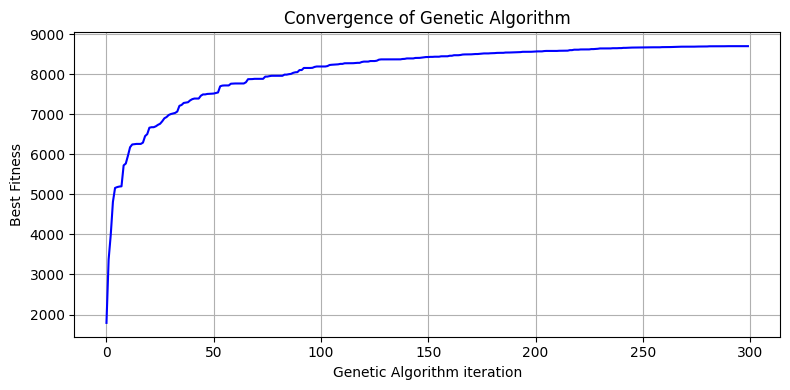

In [8]:
# Plot history of convergence
yy = np.array(best_results['history_of_best'])
xx = np.arange(len(yy))
# xx = xx[::5]; yy = yy[::5]
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(xx, yy, label='GA with WOC', ls='-', c='blue')
ax.set_xlabel("Genetic Algorithm iteration")
ax.set_ylabel("Best Fitness")
ax.set_title("Convergence of Genetic Algorithm")
plt.tight_layout()
plt.grid()


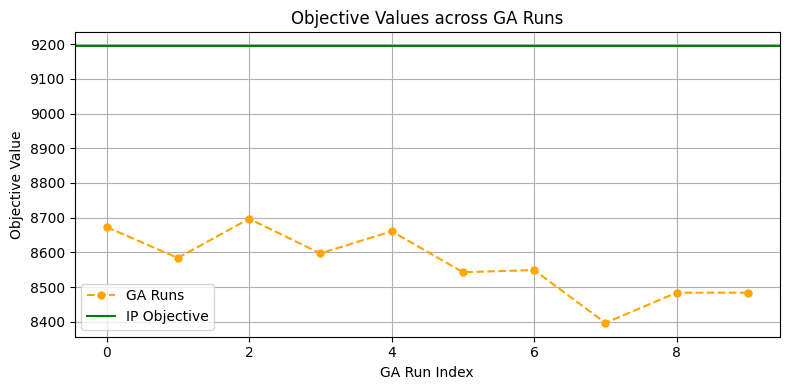

In [10]:
yy = np.array(objective_values)
xx = np.arange(len(yy))
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(xx, yy, label='GA Runs', ls='--', marker='o', ms=5, c='orange')
# plot a line for IP objective value
ax.axhline(y=obj_ip, color='green', linestyle='-', label='IP Objective')
ax.set_xlabel("GA Run Index")
ax.set_ylabel("Objective Value")
ax.set_title("Objective Values across GA Runs")
ax.legend()
plt.tight_layout()
plt.grid()
plt.show()

In [11]:
####
# Iam working on my own branch "dev_truong"